#Data preprocessing

In [19]:
!source venv/bin/activate

# this is for our data manipulations
import pandas as pd
import numpy as np

# this is for our visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'

plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

zsh:source:1: no such file or directory: venv/bin/activate


In [34]:
path = '../data/'
df = pd.read_csv(path+'insurance.csv')
df_encoded = df.copy()
df_encoded.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


###Feature engineering

Now that we have some infos about our datas, we can make feature engineering.  
It’s the possible way to create new features from previous features (bases on intuition) to train the model much more.  
We compute $x1*x2$ to find $x3$


Here, some feature interest us :  
- smoker(yes) : strongest correlation : $0.79$
- age : 2nd correlation : $0.30$
- bmi : 3rd correlation : $0.29$

So, from these features, we can do some engineering.  
Our model will be smarter because he could catch non-linear relations.

In [35]:
# one-hot-encoding smokers
df_encoded['smoker'] = df_encoded['smoker'].map({'yes': 1, 'no': 0})
# one-hot-encoding sex
df_encoded['sex'] = df_encoded['sex'].map({'male': 1, 'female': 0})
# for 'region' which has multiple categories, use one-hot encoding
df_encoded = pd.get_dummies(df_encoded, columns=['region'], drop_first=True)

df_encoded.head()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,False,False,True
1,18,1,33.770,1,0,1725.55230,False,True,False
2,28,1,33.000,3,0,4449.46200,False,True,False
3,33,1,22.705,0,0,21984.47061,True,False,False
4,32,1,28.880,0,0,3866.85520,True,False,False


We splitted regions into 3 columns with name of regions (one-hot-encoding) with True/False

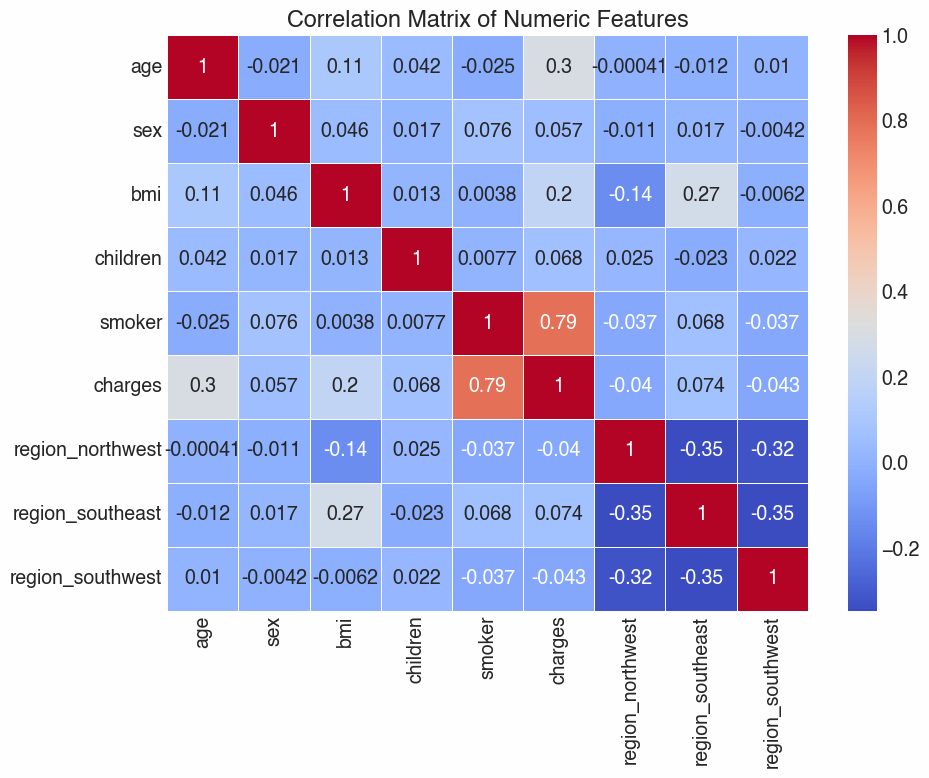

In [38]:
# correlation matrix
correlation_matrix = df_encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.show()

In [37]:
sns.scatterplot(x='age_bmi', y='charges', data=df_encoded)
plt.title('Charge Vs Age * BMI')
plt.figure(figsize=(12, 6))
plt.show()

ValueError: Could not interpret value `age_bmi` for `x`. An entry with this name does not appear in `data`.